# Utilities

In [1]:
import numpy as np
from math import ceil

import pandas as pd
from pandas import get_dummies

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
#Plotly dependancies.

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
pio.templates.default = "none"


In [3]:
#Display Utilities.

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

style_df = lambda df:df.head(50).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#FFFEE3'), 
            ('color', 'black'),
            ('font-family', 'verdana')]},
 
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#ADD8E6')]}, 
 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
 {'selector': 'tr:hover',
  'props': [('background-color', '#FFFEE3')]}
]
)

# Exploratory Data Analysis

## Understanding Features

In [4]:
#Loading the dataset.
traffic_df = pd.read_csv(r'./Data/Train/traffic.csv',sep=';')

In [5]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Hour (Coded)                           135 non-null    int64 
 1   Immobilized bus                        135 non-null    int64 
 2   Broken Truck                           135 non-null    int64 
 3   Vehicle excess                         135 non-null    int64 
 4   Accident victim                        135 non-null    int64 
 5   Running over                           135 non-null    int64 
 6   Fire vehicles                          135 non-null    int64 
 7   Occurrence involving freight           135 non-null    int64 
 8   Incident involving dangerous freight   135 non-null    int64 
 9   Lack of electricity                    135 non-null    int64 
 10  Fire                                   135 non-null    int64 
 11  Point of flooding  

* As can be seen there are 17 features and none of them are null.
* The names of each features are quite explanatory.

**Getting feature infos**

In [6]:
features = traffic_df.columns.drop('Slowness in traffic (%)')

In [7]:
feature_info_dict = {
    'Features': features,
    'Data type': [traffic_df[col].dtype for col in features],
    'Count': [traffic_df[col].size for col in features],
    'Number of Unique Values': [traffic_df[col].nunique() for col in features] ,
    'Null values': [traffic_df[col].isnull().sum() for col in features]   
}

In [8]:
feature_info = pd.DataFrame(feature_info_dict)
style_df(feature_info)

,Features,Data type,Count,Number of Unique Values,Null values
0,Hour (Coded),int64,135,27,0
1,Immobilized bus,int64,135,4,0
2,Broken Truck,int64,135,6,0
3,Vehicle excess,int64,135,2,0
4,Accident victim,int64,135,4,0
5,Running over,int64,135,3,0
6,Fire vehicles,int64,135,2,0
7,Occurrence involving freight,int64,135,2,0
8,Incident involving dangerous freight,int64,135,2,0
9,Lack of electricity,int64,135,5,0


In [9]:
def create_day(df):
    '''
    A method that processes the Hour feature of the dataframe
    to create a new feature 'Day'.
    '''
    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY']
    idx_ub = list(np.arange(26, 135, 27))
    idx_lb = [0] + [idx + 1 for idx in idx_ub[0:-1]]

    #Encoding the index bounds of dataframe for corresponding days.
    days_index = {k: v for (k, v) in zip(days, zip(idx_lb, idx_ub))}

    #Creating the day column.
    if 'Day' not in df.columns:
        df['Day'] = 0

    #Encoding is done such that Monday->1, Tuesday->2,...
    for day, idx_bnd in days_index.items():
        lb, ub = idx_bnd
        df.loc[lb:ub, 'Day'] = days.index(day) + 1

    return df

def categorise_hour(df):
    '''
    A method that creates the category variable 'Time of day'.
    '''
    times = ['Morning', 'After-noon', 'Evening', 'Night']
    hour_code = {
        'Morning': (1, 7),
        'After-noon': (8, 14),
        'Evening': (15, 21),
        'Night': (21, 27)
    }
    #Creating a feature that indicates the time of day.
    df['Time of day'] = 0

    #Morning ->1, After-noon->2, Evening->3, Night->4.
    for time, (h1, h2) in hour_code.items():
        filt = (df['Hour (Coded)'] >= h1) & (df['Hour (Coded)'] <= h2)
        df.loc[filt, 'Time of day'] = times.index(time) + 1
    
    return df



In [10]:
traffic_df = create_day(traffic_df)
traffic_df = categorise_hour(traffic_df)

## Target Variable

In [11]:
#Convesrion to float.
traffic_df['Slowness in traffic (%)'] = traffic_df['Slowness in traffic (%)'].apply(
    lambda x: str(x).replace(',', '.')).astype('float')

In [12]:
style_df(pd.DataFrame(traffic_df['Slowness in traffic (%)'].describe()))

,Slowness in traffic (%)
count,135.000000
mean,10.051852
std,4.363243
min,3.400000
25%,7.400000
50%,9.000000
75%,11.850000
max,23.400000


* The values are non-problematic with no zero entries.

In [13]:
target = traffic_df['Slowness in traffic (%)']
log_target = np.log(traffic_df['Slowness in traffic (%)'])

In [14]:
target.max()

23.4

**Distribution of target variable before applying log transformation**

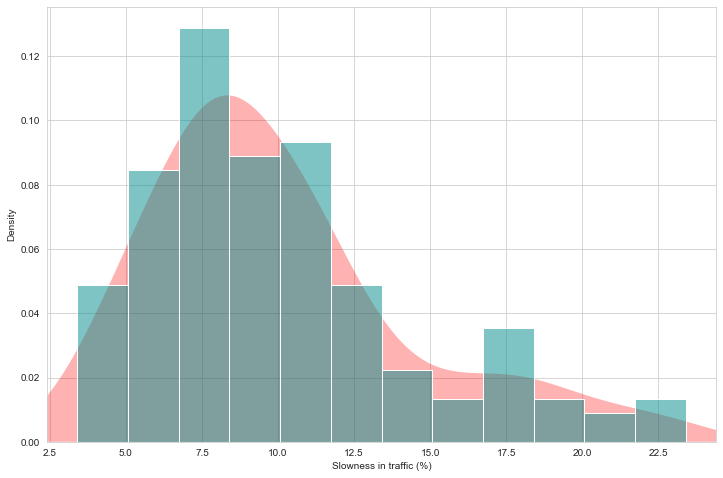

In [15]:
fig = plt.figure(figsize=(12,8))
sns.histplot(target,stat='density', color='darkcyan', alpha=0.5 )
sns.kdeplot(target, color='red', fill=True, alpha=0.3, lw = 0)
plt.xlim(target.min() -1, target.max()+1)
fig.savefig('./data_results/target_dist.PNG')

In [16]:
#Skewness and kurtosis before applying log transformation.
skew = traffic_df['Slowness in traffic (%)'].skew()
kurtosis = traffic_df['Slowness in traffic (%)'].kurt()
print(f'Skewness: {skew}, Kurtosis: {kurtosis}')

Skewness: 1.07984062533184, Kurtosis: 0.8187881392122187


**After log transformation**

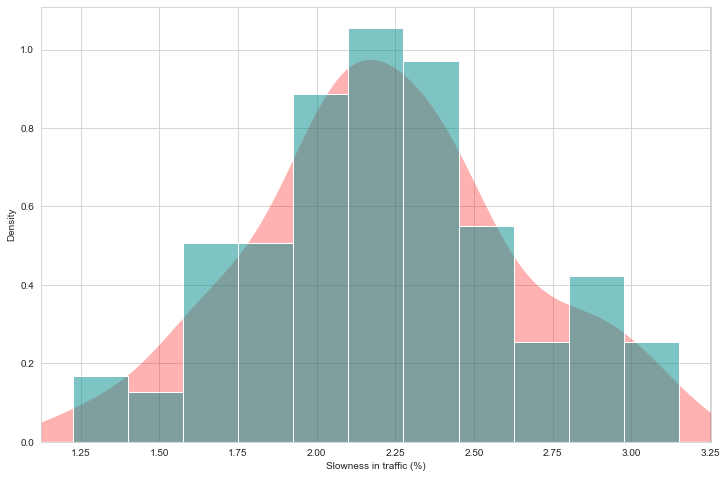

In [17]:
fig = plt.figure(figsize=(12,8))
sns.histplot(log_target,stat='density', color='darkcyan', alpha=0.5 )
sns.kdeplot(log_target, color='red', fill=True, alpha=0.3, lw = 0)
plt.xlim(log_target.min() -0.1, log_target.max() +0.1)
fig.savefig('./data_results/log_target_dist.PNG')

* Here we have applied a log transformaation on the target variable and as a result it becomes normally distributed.

In [18]:
 #traffic_df['Slowness in traffic (%)'] = log_target

In [19]:
#Skewness and kurtosis after applying log transformation.
skew = traffic_df['Slowness in traffic (%)'].skew()
kurtosis = traffic_df['Slowness in traffic (%)'].kurt()
print(f'After log transformation, Skewness: {skew}, Kurtosis: {kurtosis}')

After log transformation, Skewness: 1.07984062533184, Kurtosis: 0.8187881392122187


## Correlation Studies

In [20]:
num_features = ['Immobilized bus', 'Broken Truck', 'Vehicle excess',
       'Accident victim', 'Running over', 'Fire vehicles',
       'Occurrence involving freight', 'Incident involving dangerous freight',
       'Lack of electricity', 'Fire', 'Point of flooding', 'Manifestations',
       'Defect in the network of trolleybuses', 'Tree on the road',
       'Semaphore off', 'Intermittent Semaphore']

cat_features = ['Day', 'Time of day']

target ='Slowness in traffic (%)'

In [21]:
#Getting the correlation grid for plotting the heat map.
corr_data = traffic_df[num_features + cat_features  + [target]].corr() 

**Making heat maps**

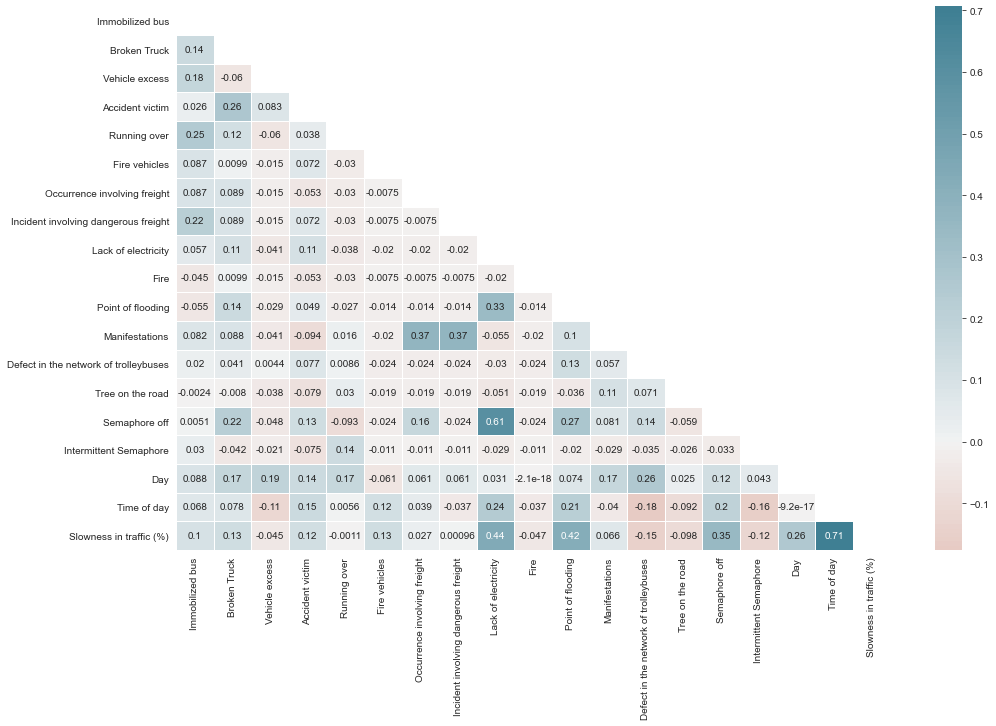

In [23]:
#Defining a figure.
fig = plt.figure(figsize=(16, 10))

#Creaing a mask for better visualiztion.
mask = np.zeros_like(corr_data, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=corr_data,
            cmap=sns.diverging_palette(20, 220, n=200),
            mask=mask,
            annot=True,
            linewidth=0.5,
            center=0)

fig.savefig('./data_results/corr_heatmap.PNG')

In [24]:
target_corr = pd.DataFrame(corr_data[target].sort_values(ascending=False))
style_df(target_corr)

,Slowness in traffic (%)
Slowness in traffic (%),1.000000
Time of day,0.706389
Lack of electricity,0.436569
Point of flooding,0.420016
Semaphore off,0.347242
Day,0.261948
Fire vehicles,0.134103
Broken Truck,0.131998
Accident victim,0.121730
Immobilized bus,0.101143


**Analsis on highly correlated features**

Any feature having an correlation of greater than 0.3 are analysed here.

* We visualize them with scatter plots and distribution plots to better understand their correlation.

In [77]:
#Getting a list of corrlated features.
filt = (target_corr[target] >= 0.3)
corr_features = list(target_corr[filt].index.drop(target))
corr_features

['Time of day', 'Lack of electricity', 'Point of flooding', 'Semaphore off']

In [78]:
#Creating a dataframe with only corrlated features.
corr_df = traffic_df[corr_features + ['Day', target]]

days_map = {1: 'Monday', 2:'Tueday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday'}

corr_df = corr_df.replace({'Day':days_map})

In [79]:
corr_df

,Time of day,Lack of electricity,Point of flooding,Semaphore off,Day,Slowness in traffic (%)
0,1,0,0,0,Monday,4.1
1,1,0,0,0,Monday,6.6
2,1,0,0,0,Monday,8.7
3,1,0,0,0,Monday,9.2
4,1,0,0,0,Monday,11.1
...,...,...,...,...,...,...
130,4,0,0,0,Friday,17.8
131,4,0,0,0,Friday,18.1
132,4,0,0,0,Friday,17.7
133,4,0,0,1,Friday,17.4


In [90]:
colormap= ['#d95f0e', (0.2, 0.6, 1), 'rgb(230,247,188)', '#bcbddc', (0.8, 0.7, 0.65)]

fig = ff.create_scatterplotmatrix(corr_df, 
                                  diag='histogram',
                                  index='Day',
                                  colormap=colormap,
                                  colormap_type='cat',
                                  height=1200, 
                                  width= 1200, 
                                 )
fig.update_layout(title="<b>Correlated Features Comparison Plots",
                  titlefont={'size': 28, 'family':'Courier New'},
                  title_x=0.5,
                  template='ggplot2',
                  plot_bgcolor='#303330')
fig.show()

**Distribution Plot for all features**

In [70]:
def plot_hist(df,ncols=4,figsize=(30,25)):
    '''
    A method that plots histogram for each column of 
    a given dataframe.
    df -> (pandas.DataFrame)
    ncols -> (int) Number of plots in a row.
    '''
    #Selecting the columns that have numeric data to plot.
    numeric_cols = list(df.select_dtypes('number'))
    tot_plots = len(numeric_cols)
    nrows = int(ceil(tot_plots/ncols))
    
    #Definging the figure and axes object.
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    
    #Plotting.
    for ax,column in zip(axes.flat,numeric_cols):
        sns.histplot(df[column], ax=ax, stat='density', color='darkcyan', alpha=0.5 )
        sns.kdeplot(df[column],ax=ax, color='red', fill=True, alpha=0.3, lw = 0)
        #sns.histplot(df[column],ax=ax,kde='True')
    #Setting off the unused axes.
    for ax in axes.flat[axes.size - 1:tot_plots - 1:-1]:
            ax.set_visible(False)
    
    fig.savefig('./data_results/feature_dist.PNG')

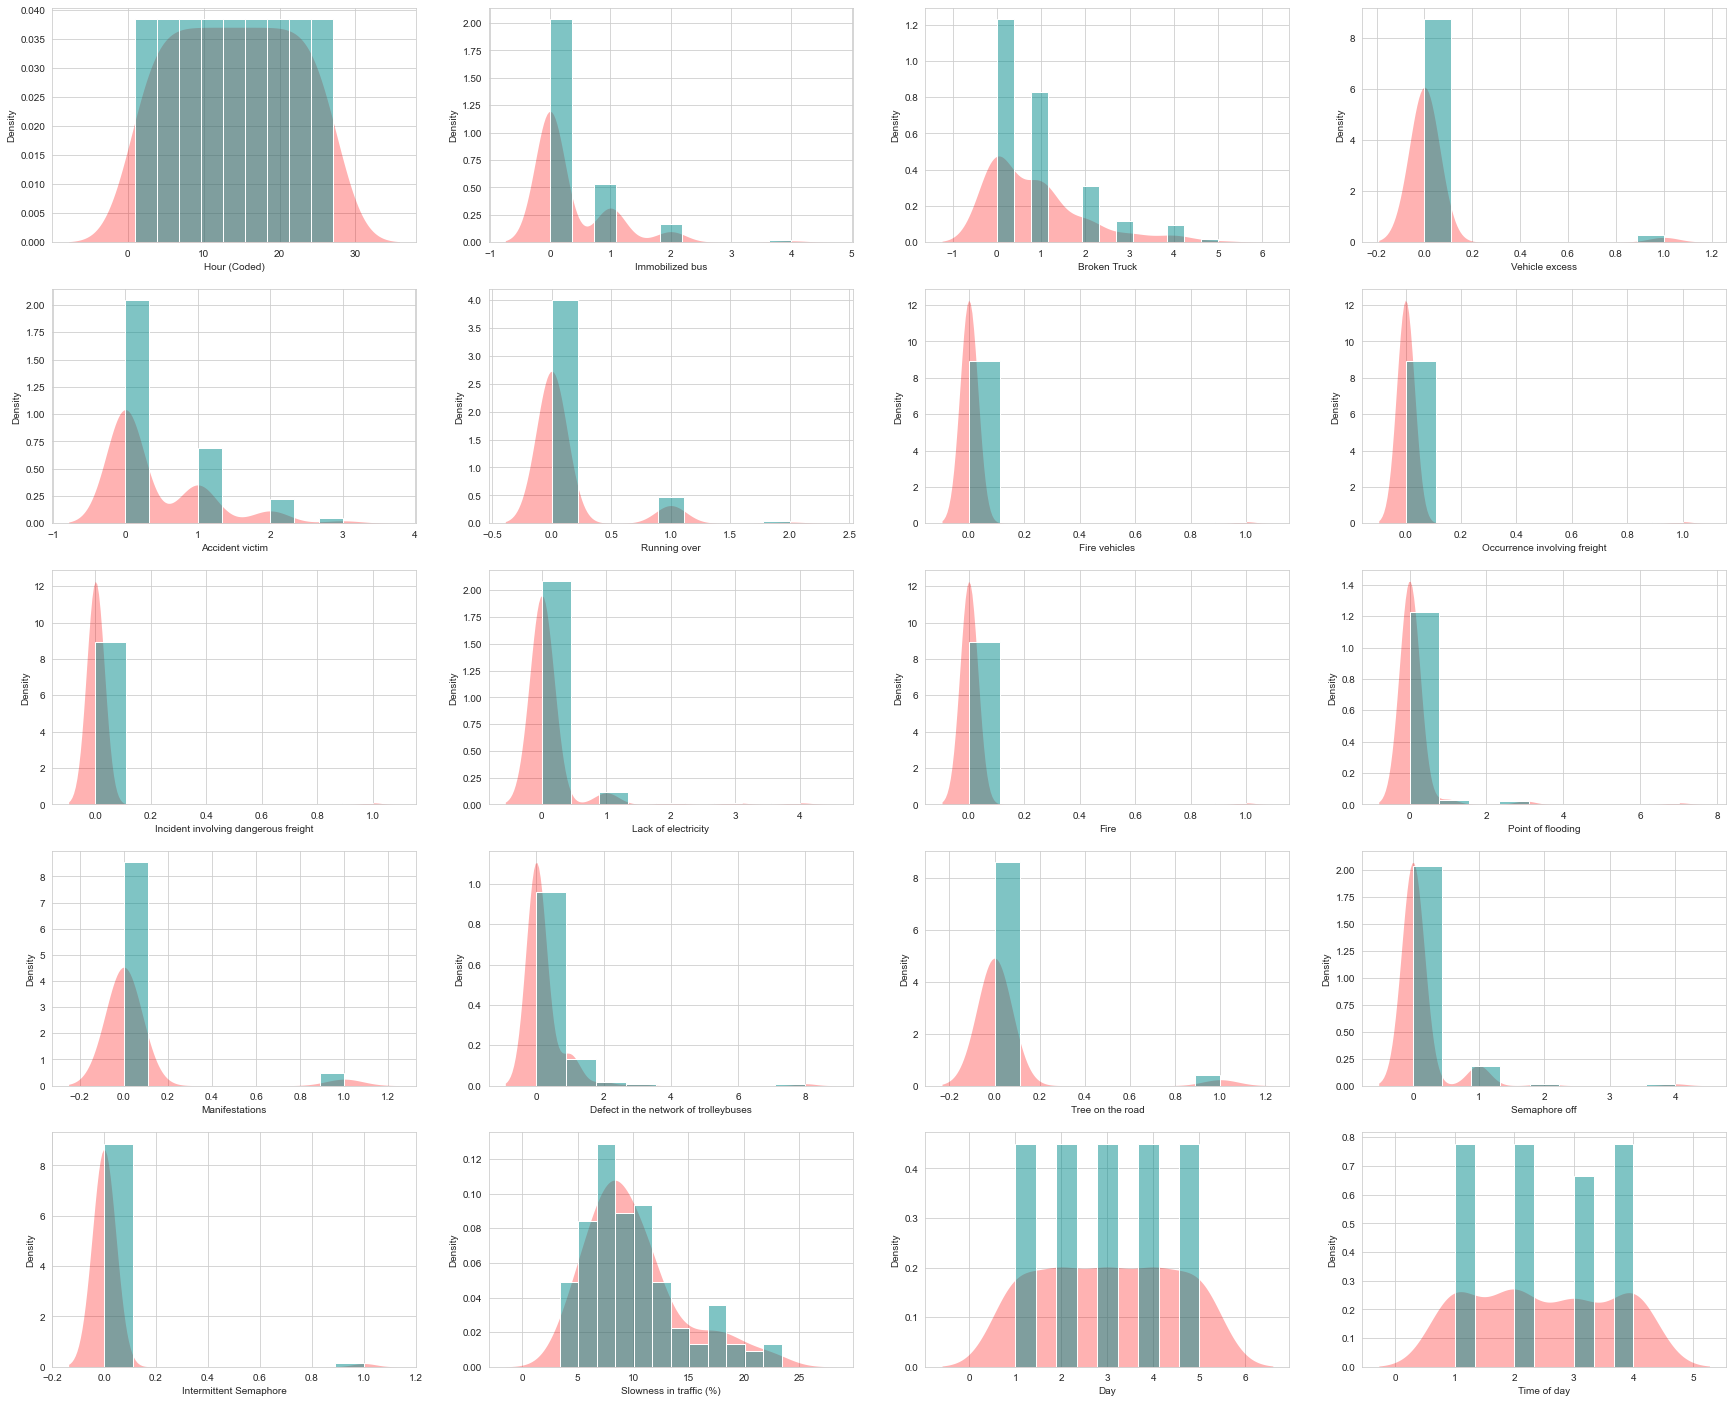

In [72]:
plot_hist(traffic_df)

## C

In [81]:
fig = plt.figure(figsize=(30,25))

<Figure size 2160x1800 with 0 Axes>

**Visualizing the slowness of traffic across the various days**

In [57]:



def plot_hour(df, figsize=(16, 8)):
    '''
    A method that plots the trends of traffic across 
    various days.
    '''
    if 'Day' not in df.columns:
        print('[ERROR INFO] "Day" feature doesnot exist...')
        return

    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY']
    #Defining the figure.
    fig, ax = plt.subplots(figsize=figsize)

    for day in df['Day'].unique():
        filt = (df['Day'] == day)
        day_df = df[filt]
        ax.plot(day_df['Hour (Coded)'],
                day_df['Slowness in traffic (%)'],
                label=days[day - 1],
                marker='X')

    ax.set_xlabel('Hour')
    ax.set_ylabel('Slowness in traffic (%)')
    ax.set_xticks(range(1, 28))
    ax.legend()
    
    fig.savefig('./data_results/time_of_day.PNG')

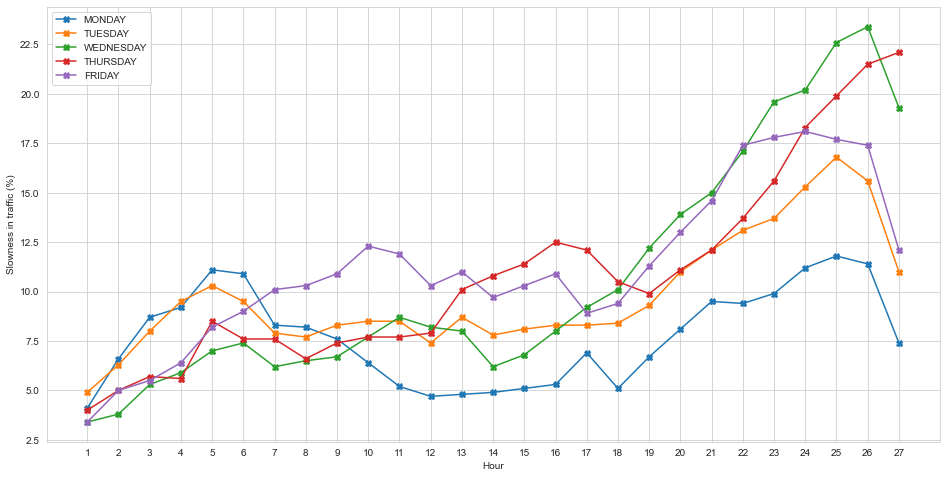

In [58]:
plot_hour(traffic_df)

* As can be seen from the above plot interruptions in traffic are high during the evenings.
* Also the highest delays occur during the evenings of wednesday.

In [ ]:
traffic_df.info()

In [ ]:
X = traffic_df.copy(deep=True)

* It would make more sense for the day and time to be treated as a category variable.
* Being category variables we can perform one-hot encoding on them.
* The hour category can be divided into four categories of morning (1-7), afternoon (8-14), evening (15-21) and night (21-27).

In [ ]:
def categorise_hour(df):
    '''
    A method that creates categories on Hour feature.
    '''
    times = ['Morning', 'After-noon', 'Evening', 'Night']
    hour_code = {
        'Morning': (1, 7),
        'After-noon': (8, 14),
        'Evening': (15, 21),
        'Night': (21, 27)
    }
    #Creating a feature that indicates the time of day.
    df['Time of day'] = 0

    #Morning ->1, After-noon->2, Evening->3, Night->4.
    for time, (h1, h2) in hour_code.items():
        filt = (df['Hour (Coded)'] >= h1) & (df['Hour (Coded)'] <= h2)
        df.loc[filt, 'Time of day'] = times.index(time) + 1
        
    #Dropping the hour column.
    df = df.drop(columns=['Hour (Coded)'], axis=1)
    
    return df


def one_hot_encode(df, category_features=['Day', 'Time of day']):
    '''
    A method that does one hot encoding on category features.
    '''
    dummies = {}
    #One hot encoding using pandas get_dummies.
    for feature in category_features:
        dummies[feature] = get_dummies(df[feature],
                                       prefix=feature,
                                       prefix_sep=' ')
        
    #Combining dummies with the dataframe.
    df = df.join(list(dummies.values()))
    
    #Dropping the initial columns that were one-hot encoded.
    df = df.drop(columns=category_features, axis=1)

    return df

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)